In [83]:
# Clear variables
%reset

Nothing done.


### Libraries

In [84]:
import pandas as pd
import pm4py
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz-11.0.0-win64/bin/'
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

### Loading data

In [85]:
log_df = pd.read_csv('data\\sepsis cases.csv', sep=',')
log_df['@@case_index'] = log_df['@@case_index'].apply(str)
log_df.rename(columns={'@@case_index': 'case:concept:name', 'case:concept:name': 'Case Name'}, inplace=True)
log_df['time:timestamp']= pd.to_datetime(log_df['time:timestamp'])
# Convert column to numeric, turning 'nan' strings to NaN values

log_df['Leucocytes'] = pd.to_numeric(log_df['Leucocytes'], errors='coerce')
log_df['LacticAcid'] = pd.to_numeric(log_df['LacticAcid'], errors='coerce')


### Studying data

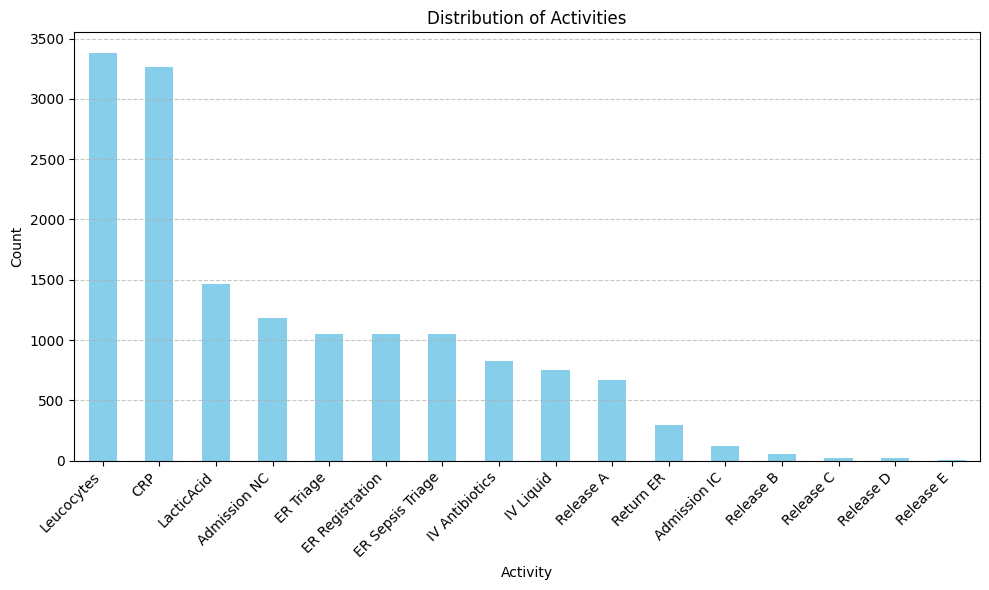

In [86]:
# Count frequency of activties

grouped_counts = log_df.groupby('concept:name').size().sort_values(ascending=False)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
grouped_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Activities')
plt.xlabel('Activity')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Nmber of events: 15214
Number of cases: 1050
Start activities: {'ER Registration': 995, 'Leucocytes': 18, 'IV Liquid': 14, 'CRP': 10, 'ER Sepsis Triage': 7, 'ER Triage': 6}
End activities: {'Release A': 393, 'Return ER': 291, 'IV Antibiotics': 87, 'Release B': 55, 'ER Sepsis Triage': 49, 'Leucocytes': 44, 'CRP': 41, 'LacticAcid': 24, 'Release C': 19, 'Admission NC': 14, 'Release D': 14, 'IV Liquid': 12, 'Release E': 5, 'ER Triage': 2}


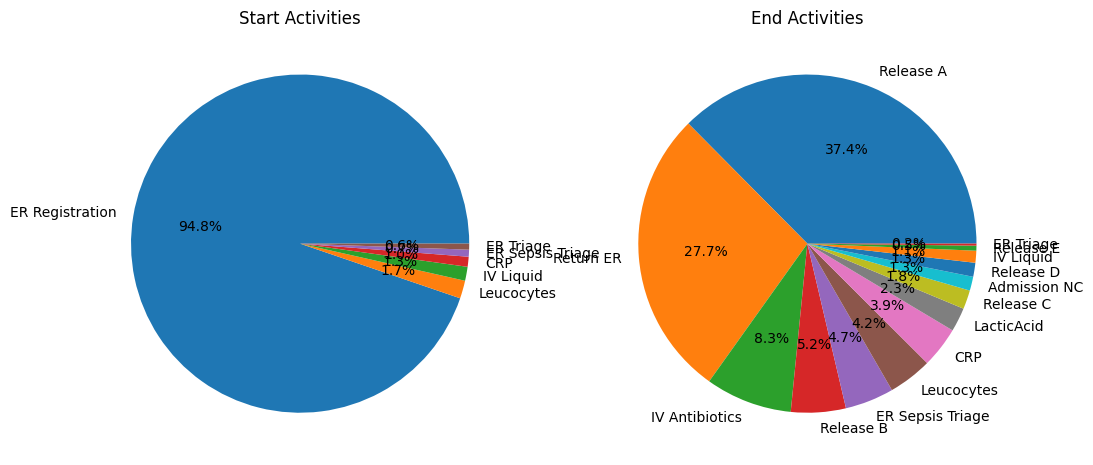

In [87]:
num_events = len(log_df)
num_cases = len(log_df['case:concept:name'].unique())
print("Nmber of events: {}\nNumber of cases: {}".format(num_events, num_cases))

start_activities = pm4py.get_start_activities(log_df)
end_activities = pm4py.get_end_activities(log_df)
start_activities =  dict(sorted(start_activities.items(), key=lambda item: item[1], reverse=True))
end_activities =  dict(sorted(end_activities.items(), key=lambda item: item[1], reverse=True))
print("Start activities: {}\nEnd activities: {}".format(start_activities, end_activities))

# Create subplots with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot pie chart for start activities
ax1.pie(start_activities.values(), labels=start_activities.keys(), autopct='%1.1f%%')
ax1.set_title('Start Activities')

# Plot pie chart for end activities
ax2.pie(end_activities.values(), labels=end_activities.keys(), autopct='%1.1f%%')
ax2.set_title('End Activities')

plt.show()

In [88]:
filtered_log_dfq = pm4py.filter_start_activities(log_df, ['ER Registration'])
filtered_log_dfq = pm4py.filter_end_activities(filtered_log_dfq, ['IV Antibiotics'])

print("Given {} total cases in the log we have {} cases whose final activity is 'IV Antibiotics'".format(num_cases, len(filtered_log_dfq['case:concept:name'].unique())))

Given 1050 total cases in the log we have 82 cases whose final activity is 'IV Antibiotics'


In [89]:
# Filter the DataFrame for rows where @@classifier is 'ER Registration'
filtered_log_dfw = log_df[log_df['@@classifier'] == 'ER Registration']

# Select Diagnostic columns
diagnostic_columns = filtered_log_dfw.filter(regex='^Diagnostic.*')

# Initialize a dictionary to hold the counts
counts = {}

for col in diagnostic_columns.columns:
    value_counts = diagnostic_columns[col].value_counts(dropna=False)
    counts[col] = {
        'True': value_counts.get(True, 0),
        'False': value_counts.get(False, 0),
    }

# Convert the dictionary to a DataFrame
result_df = pd.DataFrame(counts).T.fillna(0)
result_df


,True,False
DiagnosticBlood,823,227
DiagnosticArtAstrup,297,753
DiagnosticIC,848,202
DiagnosticSputum,29,1021
DiagnosticLiquor,5,1045
DiagnosticOther,10,1040
DiagnosticXthorax,785,265
DiagnosticUrinaryCulture,476,574
DiagnosticLacticAcid,804,246
DiagnosticUrinarySediment,519,531


### Filtering data
- Incomplete cases according to start and end activity
- Incomplete cases according to activity 'ER Registration' and basic medical procedures
- Incomplete cases according to Leucocytes and CRP measurements, that are NaN (Not a Number) in corresponding activities
- (?) checking if any case lasts less than 1 hour

In [126]:
# Incomplete cases according to start and end activity

# filtered_log_df = pm4py.filter_end_activities(log_df, ['Release A', 'Release B', 'Release E', 'Release C', 'Release D', 'Return ER', 'IV Antibiotics'])
filtered_log_df = pm4py.filter_end_activities(log_df, ['Release A', 'Release B', 'Release E', 'Release C', 'Release D', 'Return ER'])
filtered_log_df = pm4py.filter_start_activities(filtered_log_df, ['ER Registration', 'ER Sepsis Triage', 'ER Triage'])

print("Given {} total cases in the log we have {} cases that comply with constraints for complete cases according to start and end activity".format(num_cases, len(filtered_log_df['case:concept:name'].unique())))

Given 1050 total cases in the log we have 743 cases that comply with constraints for complete cases according to start and end activity


In [127]:
#################### DRAFT ####################

# t = filtered_log_df[filtered_log_df['org:group'] == '?']
# len(t['case:concept:name'].unique())
# w 282 przypadkach brak org group

# t = filtered_log_df[filtered_log_df['DiagnosticBlood'] == False]
# len(t['case:concept:name'].unique())
# w 106 przypadkach brak diagnostyki krwi przy ER Registration
t = filtered_log_df[filtered_log_df['DiagnosticBlood'] == True]
len(t['case:concept:name'].unique())
# w 721 przypadkach krew zbadana przy rejestracji

# t = filtered_log_df[filtered_log_df['InfectionSuspected'] == 'nan']
# filtered_log_df.InfectionSuspected.isna().sum()
# len(t['case:concept:name'].unique())
#
# len(filtered_log_df)

640

In [128]:
# Incomplete cases according to activity ‘ER Registration’ and basic medical procedures

filtered = filtered_log_df[filtered_log_df['@@classifier'] == 'ER Registration']
# Count the number of cases where none of blood test was done or the basic diagnostic IC
logical_sum_filter = (filtered[['DiagnosticBlood', 'DiagnosticIC', 'DiagnosticLacticAcid', 'DiagnosticArtAstrup']].any(axis=1) == False)
uncompleted_ER_Registration = logical_sum_filter.sum()

print("Given {} total cases in the log we have {} cases that passed incomplete ER Registration".format(num_cases, uncompleted_ER_Registration))

# Get the unique values from the 'case:concept:name' column
unique_cases = filtered[logical_sum_filter]['case:concept:name'].unique()
filtered_log_df = filtered_log_df[~filtered_log_df['case:concept:name'].isin(unique_cases)]

print("Given {} total cases in the log we have {} cases comply the constraints according to start/end activity and completeness of medical procedures in ER Registration activity".format(num_cases, len(filtered_log_df['case:concept:name'].unique())))



Given 1050 total cases in the log we have 84 cases that passed incomplete ER Registration
Given 1050 total cases in the log we have 659 cases comply the constraints according to start/end activity and completeness of medical procedures in ER Registration activity


In [129]:
# Incomplete cases according to Leucocytes and CRP measurements, that are NaN in corresponding activities
leucocytes_nan_cases = filtered_log_df[ filtered_log_df['concept:name'] == 'Leucocytes' ][ ['Leucocytes', 'case:concept:name'] ]
nan_leucocytes_cases = leucocytes_nan_cases[leucocytes_nan_cases['Leucocytes'].isna()]
unique_nan_leucocytes_cases = nan_leucocytes_cases['case:concept:name'].unique()

print("Given {} total cases in the log we have {} cases passed incomplete Leucocytes measurement, giving unknown value".format(num_cases, len(unique_nan_leucocytes_cases)))

crp_nan_cases = filtered_log_df[filtered_log_df['concept:name'] == 'CRP'][['CRP', 'case:concept:name']]
nan_crp_cases = crp_nan_cases[crp_nan_cases['CRP'].isna()]
unique_nan_crp_cases = nan_crp_cases['case:concept:name'].unique()

print("Given {} total cases in the log we have {} cases passed incomplete Leucocytes measurement, giving unknown value".format(num_cases, len(unique_nan_crp_cases)))

filtered_log_df = filtered_log_df[~filtered_log_df['case:concept:name'].isin(unique_nan_leucocytes_cases)]
filtered_log_df = filtered_log_df[~filtered_log_df['case:concept:name'].isin(unique_nan_crp_cases)]

print("Common cases for CRP and Leucocytes:",  len(set(unique_nan_leucocytes_cases) & set(unique_nan_crp_cases)))

print("Given {} total cases in the log we have {} cases comply the constraints according to start/end activity, completeness of medical procedures in ER Registration activity and completeness of Leucocytes and CRP measurements".format(num_cases, len(filtered_log_df['case:concept:name'].unique())))


Given 1050 total cases in the log we have 21 cases passed incomplete Leucocytes measurement, giving unknown value
Given 1050 total cases in the log we have 52 cases passed incomplete Leucocytes measurement, giving unknown value
Common cases for CRP and Leucocytes: 10
Given 1050 total cases in the log we have 596 cases comply the constraints according to start/end activity, completeness of medical procedures in ER Registration activity and completeness of Leucocytes and CRP measurements


All cases are longer than 1 hour


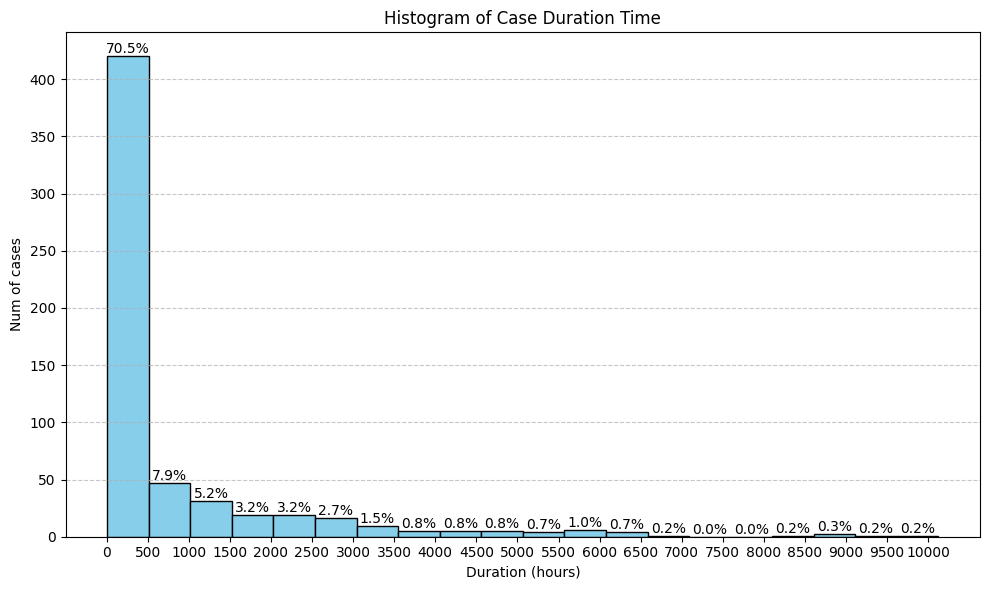

In [154]:
# Case duration
case_durations = pm4py.get_all_case_durations(filtered_log_df, activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp')
case_durations_hours = [duration / (3600) for duration in case_durations]
case_durations_hours.sort(reverse=False)

if any(duration < 1 for duration in case_durations_hours):
    print("There is at least one case that lasts lower than 1 hour")
else:
    print("All cases are longer than 1 hour")

# Plotting the histogram
plt.figure(figsize=(10, 6))
# plt.hist(case_durations_hours, bins=20, color='skyblue', edgecolor='black')
n, bins, patches = plt.hist(case_durations_hours, bins=20, color='skyblue', edgecolor='black')

plt.title('Histogram of Case Duration Time')
plt.xlabel('Duration (hours)')
plt.ylabel('Num of cases')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.xticks(np.arange(0, max(case_durations_hours) + 1, 500))

# Add percentage labels on the bars
for i in range(len(patches)):
    x = patches[i].get_x() + patches[i].get_width() / 2
    y = patches[i].get_height()
    percentage = '{:.1f}%'.format(100 * y / len(case_durations_hours))
    plt.text(x, y, percentage, ha='center', va='bottom')
plt.show()

### DFG discovery

In [ ]:
## Import the dfg_discovery algorithm
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
## Import the dfg visualization object
from pm4py.visualization.dfg import visualizer as dfg_visualization

## Convert to log format
filetered_log = log_converter.apply(filtered_log_df)
#Create graph from log
dfg = dfg_discovery.apply(filetered_log)
# Visualise
gviz = dfg_visualization.apply(dfg, log=filetered_log, variant=dfg_visualization.Variants.FREQUENCY)
dfg_visualization.view(gviz)

### Inductive Miner

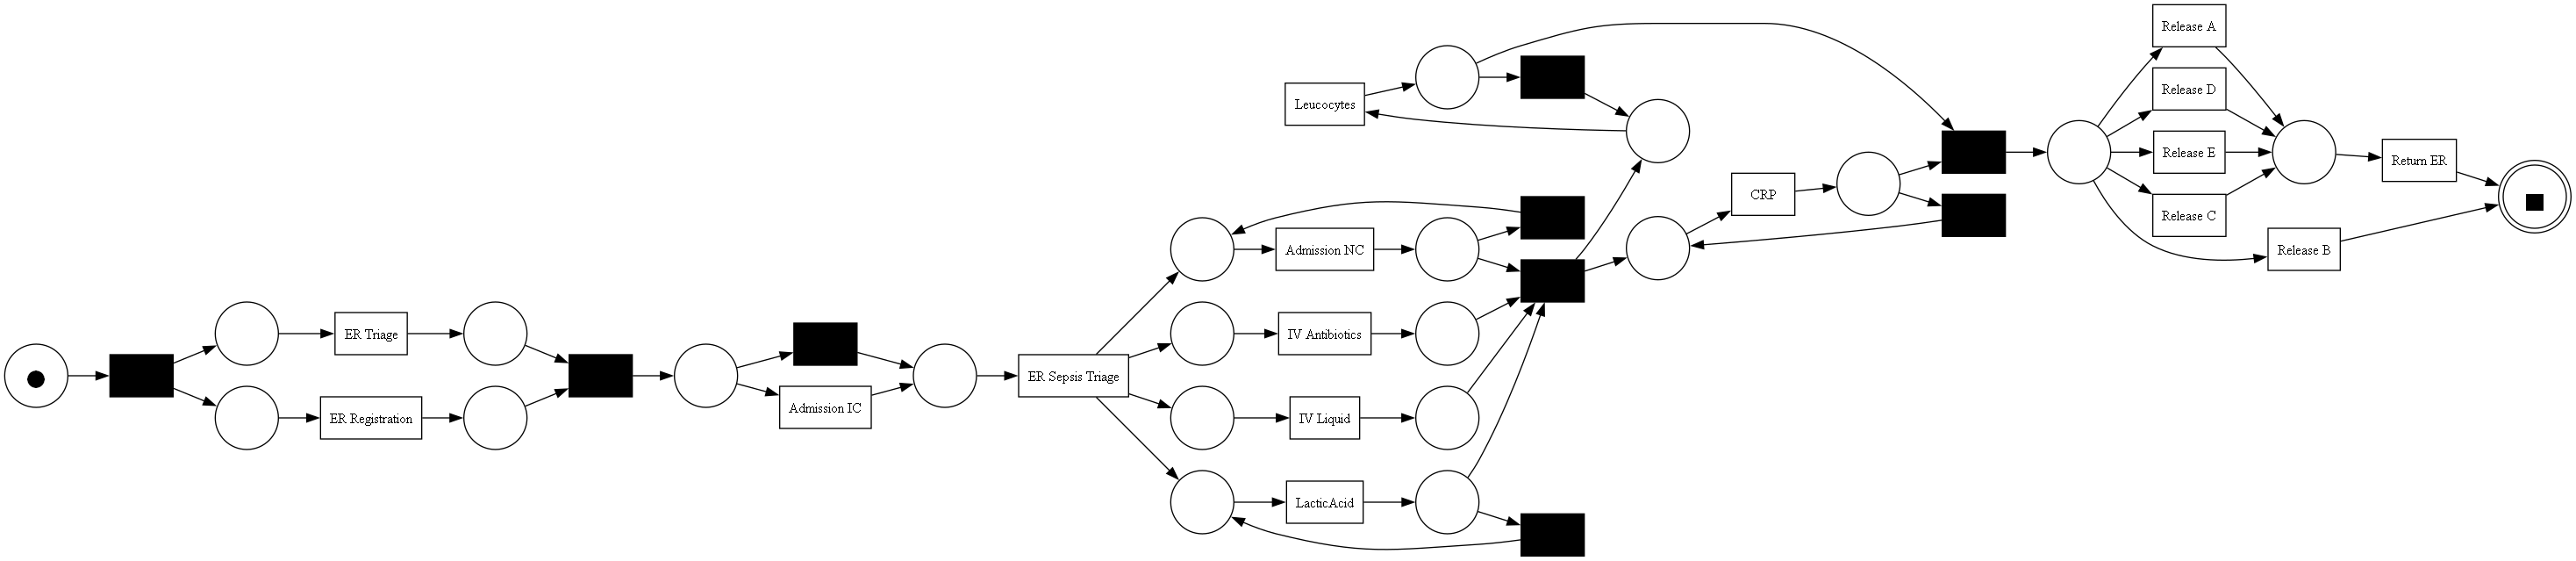

In [136]:
# Discover the model with Inductive Miner

net, im, fm = pm4py.discover_petri_net_inductive(filtered_log_df, noise_threshold= 0.95)
pm4py.view_petri_net(net, im, fm, format='png')


In [ ]:
# Discover the model with Inductive Miner

filetered_log = log_converter.apply(filtered_log_dfq)
#Create graph from log
dfg = dfg_discovery.apply(filetered_log)
# Visualise
gviz = dfg_visualization.apply(dfg, log=filetered_log, variant=dfg_visualization.Variants.FREQUENCY)
dfg_visualization.view(gviz)